# Matching 👬

In [177]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from causalml.match import NearestNeighborMatch, create_table_one

In [178]:
data = pd.read_csv('/home/juliusdoebelt/documents/repos/Diploma_Thesis/data/preprocessed_data.csv')
# only select participants from the years 2008/09, 2009/10, and 2010/11
data = data[(data['year_3rd'] == "2008/09") | (data['year_3rd'] == "2009/10") | (data['year_3rd'] == "2010/11")]
important_variables = ["treat", "oweight", "sportsclub", "sport_hrs", "kommheard", "kommgotten", "kommused", "female", "born_germany", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban", "yob", "mob", "abi_p", "real_p", "haupt_p"]
data = data[important_variables]

In [179]:
# Create a single indicator for missing education data
data['education_unknown'] = np.where(data[['abi_p', 'real_p', 'haupt_p']].isna().all(axis=1), 1, 0)

# Fill NAs in the individual education columns with 0 to indicate that the specific education level is not applicable/answered
data[['abi_p', 'real_p', 'haupt_p']] = data[['abi_p', 'real_p', 'haupt_p']].fillna(0)
print(data.columns)

Index(['treat', 'oweight', 'sportsclub', 'sport_hrs', 'kommheard',
       'kommgotten', 'kommused', 'female', 'born_germany', 'parent_nongermany',
       'sportsclub_4_7', 'music_4_7', 'urban', 'yob', 'mob', 'abi_p', 'real_p',
       'haupt_p', 'education_unknown'],
      dtype='object')


In [180]:
# create variable if stats for sportsclub and music at ages 4-7 are unknown
data['kindergarten_stats_unknown'] = np.where(data[['sportsclub_4_7', 'music_4_7']].isna().all(axis=1), 1, 0)
data[['sportsclub_4_7', 'music_4_7']] = data[['sportsclub_4_7', 'music_4_7']].fillna(0)

In [181]:
# create variable if no statement was made if parents are german
data['parent_nongerman_unknown'] = np.where(data['parent_nongermany'].isna(), 1, 0)
data['parent_nongermany'] = data['parent_nongermany'].fillna(0)

In [182]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [183]:
# create dummy variables for year of birth
data['yob'] = data['yob'].astype(str)
data = pd.get_dummies(data, columns=['yob'], drop_first=True, dtype=int)

In [184]:
print(data.describe())

             treat      oweight   sportsclub    sport_hrs    kommheard  \
count  9371.000000  9371.000000  9371.000000  9371.000000  9371.000000   
mean      0.536442     0.142354     0.452033     4.820297     0.231139   
std       0.498697     0.349432     0.497720     4.219149     0.421583   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     2.000000     0.000000   
50%       1.000000     0.000000     0.000000     4.000000     0.000000   
75%       1.000000     0.000000     1.000000     6.500000     0.000000   
max       1.000000     1.000000     1.000000    31.000000     1.000000   

        kommgotten     kommused       female  born_germany  parent_nongermany  \
count  9371.000000  9371.000000  9371.000000   9371.000000        9371.000000   
mean      0.131363     0.081208     0.570910      0.957849           0.132110   
std       0.337815     0.273169     0.494973      0.200945           0.338628   
min      

# Propensity Score Estimation using Logistic Regression

In [185]:
# Prepare the data
independent_variables = ["female", "born_germany", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban", 'yob_1998.0', 'yob_1999.0', 'yob_2000.0', 'yob_2001.0',
       'yob_2002.0', 'yob_2003.0', 'abi_p', 'real_p', 'haupt_p', 'education_unknown', 'kindergarten_stats_unknown', 'parent_nongerman_unknown']
X = data[independent_variables]


In [186]:
# Generate interaction and quadratic terms
def generate_interactions_and_quadratics(data, feature_columns):
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    interaction_quadratic_matrix = poly.fit_transform(data[feature_columns])
    feature_names = poly.get_feature_names_out(input_features=feature_columns)
    interaction_quadratic_df = pd.DataFrame(interaction_quadratic_matrix, columns=feature_names)
    return interaction_quadratic_df

interactions_terms = ["female", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban"]#, 'abi_p', 'real_p', 'haupt_p']

# Generate interaction and quadratic terms on standardized data
interaction_quadratic_df = generate_interactions_and_quadratics(X, interactions_terms)

# Combine with the original standardized data
X_expanded = pd.concat([X, interaction_quadratic_df], axis=1)

# Remove duplicate columns if any
X_expanded = X_expanded.loc[:, ~X_expanded.columns.duplicated()]

In [187]:
X_expanded.describe()

,female,born_germany,parent_nongermany,sportsclub_4_7,music_4_7,urban,yob_1998.0,yob_1999.0,yob_2000.0,yob_2001.0,...,parent_nongermany^2,parent_nongermany sportsclub_4_7,parent_nongermany music_4_7,parent_nongermany urban,sportsclub_4_7^2,sportsclub_4_7 music_4_7,sportsclub_4_7 urban,music_4_7^2,music_4_7 urban,urban^2
count,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,...,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000
mean,0.570910,0.957849,0.132110,0.515420,0.431971,0.592893,0.013446,0.131043,0.327393,0.326006,...,0.132110,0.053890,0.047807,0.086437,0.515420,0.260378,0.308078,0.431971,0.270195,0.592893
std,0.494973,0.200945,0.338628,0.499789,0.495377,0.491321,0.115180,0.337465,0.469287,0.468774,...,0.338628,0.225812,0.213369,0.281023,0.499789,0.438864,0.461724,0.495377,0.444084,0.491321
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
# Calculate correlation matrix
correlation_matrix = X_expanded.corr()

# Display correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Calculate VIF for each feature
vif_df = calculate_vif(X_expanded)

# Display VIF
print("\nVariance Inflation Factor (VIF):")
print(vif_df)

# Identify features with high VIF
high_vif_features = vif_df[vif_df["VIF"] > 10]["feature"]
print("\nFeatures with high VIF (greater than 10):")
print(high_vif_features)


Variance Inflation Factor (VIF):
                             feature           VIF
0                             female  1.060797e+04
1                       born_germany  1.257460e+00
2                  parent_nongermany  3.448279e+08
3                     sportsclub_4_7  3.555918e+03
4                          music_4_7  1.680948e+06
5                              urban  9.243573e+02
6                         yob_1998.0  1.876883e+01
7                         yob_1999.0  1.535088e+02
8                         yob_2000.0  2.958917e+02
9                         yob_2001.0  2.947015e+02
10                        yob_2002.0  2.130947e+02
11                        yob_2003.0  5.132643e+00
12                             abi_p  1.062373e+02
13                            real_p  1.032798e+02
14                           haupt_p  9.254842e+00
15                 education_unknown  3.871315e+02
16        kindergarten_stats_unknown  1.202341e+00
17          parent_nongerman_unknown  1.027650e+

## Multicollinearity
When creating interaction terms between all variables (including squares of all variables), there occured multicollinearity. One column could be expressed as linear combination from one or more other columns. 

In [189]:
X_expanded = X_expanded.drop(columns=['urban^2', 'music_4_7^2', 'sportsclub_4_7^2', 'female^2'])
X_expanded.head()
print(X_expanded.columns)

Index(['female', 'born_germany', 'parent_nongermany', 'sportsclub_4_7',
       'music_4_7', 'urban', 'yob_1998.0', 'yob_1999.0', 'yob_2000.0',
       'yob_2001.0', 'yob_2002.0', 'yob_2003.0', 'abi_p', 'real_p', 'haupt_p',
       'education_unknown', 'kindergarten_stats_unknown',
       'parent_nongerman_unknown', 'female parent_nongermany',
       'female sportsclub_4_7', 'female music_4_7', 'female urban',
       'parent_nongermany^2', 'parent_nongermany sportsclub_4_7',
       'parent_nongermany music_4_7', 'parent_nongermany urban',
       'sportsclub_4_7 music_4_7', 'sportsclub_4_7 urban', 'music_4_7 urban'],
      dtype='object')


In [190]:
y = data['treat']

# Fit the model
logit_model = sm.Logit(y, X_expanded)
result = logit_model.fit()

# Get the propensity scores
X_expanded['ps'] = result.predict(X_expanded)

X_expanded['treat'] = y
print(X_expanded['ps'])

Optimization terminated successfully.
         Current function value: 0.629523
         Iterations 5
0       0.740878
1       0.631798
2       0.637824
3       0.315696
4       0.661809
          ...   
9366    0.270137
9367    0.648583
9368    0.639023
9369    0.723104
9370    0.378072
Name: ps, Length: 9371, dtype: float64


In [191]:
X_expanded[X_expanded['treat'] == 0]['ps'].describe()

count    4344.000000
mean        0.472547
std         0.171804
min         0.242091
25%         0.316877
50%         0.379030
75%         0.659424
max         0.846186
Name: ps, dtype: float64

In [192]:
X_expanded[X_expanded['treat'] == 1]['ps'].describe()

count    5027.000000
mean        0.591656
std         0.152069
min         0.242091
25%         0.458014
50%         0.652096
75%         0.695506
max         0.819175
Name: ps, dtype: float64

In [193]:
X_expanded.describe().round(2)

,female,born_germany,parent_nongermany,sportsclub_4_7,music_4_7,urban,yob_1998.0,yob_1999.0,yob_2000.0,yob_2001.0,...,female urban,parent_nongermany^2,parent_nongermany sportsclub_4_7,parent_nongermany music_4_7,parent_nongermany urban,sportsclub_4_7 music_4_7,sportsclub_4_7 urban,music_4_7 urban,ps,treat
count,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,...,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00,9371.00
mean,0.57,0.96,0.13,0.52,0.43,0.59,0.01,0.13,0.33,0.33,...,0.34,0.13,0.05,0.05,0.09,0.26,0.31,0.27,0.54,0.54
std,0.49,0.20,0.34,0.50,0.50,0.49,0.12,0.34,0.47,0.47,...,0.47,0.34,0.23,0.21,0.28,0.44,0.46,0.44,0.17,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00
25%,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.34,0.00
50%,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.64,1.00
75%,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,...,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.69,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.85,1.00


## Checking for Common Support

/home/juliusdoebelt/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/juliusdoebelt/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


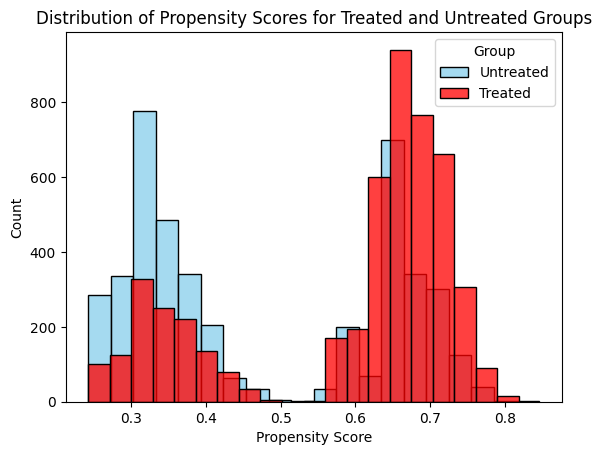

In [194]:
sns.histplot(X_expanded[X_expanded['treat'] == 0]['ps'], color="skyblue", label='Untreated', bins=20)
sns.histplot(X_expanded[X_expanded['treat'] == 1]['ps'], color="red", label='Treated', bins=20)

plt.legend(title='Group')
plt.xlabel('Propensity Score')
plt.title('Distribution of Propensity Scores for Treated and Untreated Groups')
plt.show()

## Evaluate covariate distribution for range of the propensity score

In [196]:
# add outcome variables to X_expanded
X_expanded['oweight'] = data['oweight']
X_expanded['sportsclub'] = data['sportsclub']
X_expanded['sport_hrs'] = data['sport_hrs']
# add survey questions to X_expanded
X_expanded['kommheard'] = data['kommheard']
X_expanded['kommgotten'] = data['kommgotten']
X_expanded['kommused'] = data['kommused']

In [197]:
X_expanded[X_expanded['treat']==1].describe().round(2)

,female,born_germany,parent_nongermany,sportsclub_4_7,music_4_7,urban,yob_1998.0,yob_1999.0,yob_2000.0,yob_2001.0,...,sportsclub_4_7 urban,music_4_7 urban,ps,treat,oweight,sportsclub,sport_hrs,kommheard,kommgotten,kommused
count,5027.00,5027.00,5027.00,5027.00,5027.00,5027.00,5027.00,5027.00,5027.00,5027.00,...,5027.00,5027.00,5027.00,5027.0,5027.00,5027.00,5027.00,5027.00,5027.00,5027.00
mean,0.58,0.96,0.14,0.49,0.44,0.74,0.01,0.15,0.33,0.33,...,0.37,0.34,0.59,1.0,0.14,0.45,4.78,0.41,0.24,0.15
std,0.49,0.21,0.35,0.50,0.50,0.44,0.12,0.35,0.47,0.47,...,0.48,0.47,0.15,0.0,0.34,0.50,4.27,0.49,0.43,0.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.24,1.0,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.46,1.0,0.00,0.00,2.00,0.00,0.00,0.00
50%,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.65,1.0,0.00,0.00,4.00,0.00,0.00,0.00
75%,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,...,1.00,1.00,0.70,1.0,0.00,1.00,6.00,1.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.82,1.0,1.00,1.00,31.00,1.00,1.00,1.00


In [198]:
index_treated = X_expanded[X_expanded['treat'] == 1].index
index_control = X_expanded[X_expanded['treat'] == 0].index

# Perform matching
matcher = NearestNeighborMatch(replace=True, ratio=1, random_state=42)
matched_data = matcher.match(data=X_expanded, treatment_col='treat', score_cols=['ps'])

      female  born_germany  parent_nongermany  sportsclub_4_7  music_4_7  \
0          0             1                0.0             0.0        1.0   
4          0             1                0.0             0.0        0.0   
5          1             1                0.0             1.0        1.0   
7          0             1                0.0             1.0        0.0   
8          1             1                0.0             0.0        0.0   
...      ...           ...                ...             ...        ...   
1662       1             1                1.0             0.0        1.0   
615        0             1                0.0             1.0        0.0   
99         1             1                0.0             1.0        0.0   
16         1             1                0.0             1.0        0.0   
1530       1             1                0.0             0.0        1.0   

      urban  yob_1998.0  yob_1999.0  yob_2000.0  yob_2001.0  ...  \
0       1.0        

In [199]:
treated_outcome = matched_data[matched_data['treat'] == 1][['oweight', 'sportsclub', 'sport_hrs', 'kommheard', 'kommgotten', 'kommused']]
control_outcome = matched_data[matched_data['treat'] == 0][['oweight', 'sportsclub', 'sport_hrs', 'kommheard', 'kommgotten', 'kommused']]

In [200]:
assert len(treated_outcome) == len(control_outcome)

In [201]:
att = treated_outcome.mean() - control_outcome.mean()

In [202]:
print(f"Mean outcome for treated: {treated_outcome.mean()}")
print(f"Mean outcome for control: {control_outcome.mean()}")
print(f"Average Treatment Effect on the Treated (ATT): {att}")

Mean outcome for treated: oweight       0.135071
sportsclub    0.447782
sport_hrs     4.779988
kommheard     0.406604
kommgotten    0.240501
kommused      0.148001
dtype: float64
Mean outcome for control: oweight       0.130296
sportsclub    0.459519
sport_hrs     4.415059
kommheard     0.019694
kommgotten    0.002984
kommused      0.002984
dtype: float64
Average Treatment Effect on the Treated (ATT): oweight       0.004774
sportsclub   -0.011737
sport_hrs     0.364929
kommheard     0.386911
kommgotten    0.237517
kommused      0.145017
dtype: float64


### Evaluation
The long-term results in the original study are not significant. Therefore it's probabaly not a good idea to base the comparison of the methods on the difference between DiD estimates and PSM estimates. The ATT is highly sensitive to inclusion of seemingly unrelevant variables (excluding parent_nongerman_unknown chnages the results in a way that makes them pretty similar to what would have been expected).

In [203]:
create_table_one(data=matched_data,
                 treatment_col='treat',
                 features=['female', 'born_germany', 'parent_nongermany', 'sportsclub_4_7', 'music_4_7', 'urban', 'yob_1998.0', 'yob_1999.0', 'yob_2000.0',
                            'yob_2001.0', 'yob_2002.0', 'yob_2003.0', 'abi_p', 'real_p', 'haupt_p', 'education_unknown', 'female parent_nongermany',
                            'female sportsclub_4_7', 'female music_4_7', 'female urban', 'parent_nongermany^2', 'parent_nongermany sportsclub_4_7',
                            'parent_nongermany music_4_7', 'parent_nongermany urban', 'sportsclub_4_7 music_4_7', 'sportsclub_4_7 urban', 'music_4_7 urban',
                            'kindergarten_stats_unknown', 'parent_nongerman_unknown']
                )

,Control,Treatment,SMD
Variable,,,
n,5027,5027,
abi_p,0.08 (0.26),0.08 (0.27),0.0082
born_germany,0.96 (0.19),0.96 (0.21),-0.0277
education_unknown,0.84 (0.37),0.84 (0.37),-0.0059
female,0.58 (0.49),0.58 (0.49),0.0008
female music_4_7,0.29 (0.45),0.28 (0.45),-0.0088
female parent_nongermany,0.08 (0.27),0.08 (0.27),-0.0045
female sportsclub_4_7,0.29 (0.45),0.29 (0.46),0.0083
female urban,0.43 (0.50),0.43 (0.49),-0.0084
